In [1]:
%load_ext autoreload

# Enable autoreload for all modules
%autoreload 2


import data_loader
import numpy as np 
import matplotlib.pyplot as plt
import torch

from graph_plotting import graph_2D
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool
from models import graph_classifier, gnn_models
from torch_geometric.loader import DataLoader
from torch_geometric.loader import NeighborLoader, GraphSAINTRandomWalkSampler

from loader.custom_loader import RandomWalkIterator, NeighborIterator, RectangularIterator

#import torch_geometric

from evaluation import evaluation

In [2]:
octa500_loader_4_cls = data_loader.RetinaLoaderTorch("/home/laurin/Documents/octa_retina/graphs", "/home/laurin/Documents/octa_retina/labels.xlsx", two_cls= False)
octa500_loader_2_cls = data_loader.RetinaLoaderTorch("/home/laurin/Documents/octa_retina/graphs", "/home/laurin/Documents/octa_retina/labels.xlsx", two_cls= True)

In [3]:
np.random.seed(0)

work_data = octa500_loader_4_cls.line_data

train_mask = np.random.choice(np.arange(0, len(work_data)), size= int(len(work_data)*0.8), replace = False)
test_mask = np.delete(np.arange(0, len(work_data)), train_mask)

train_list_bin = []
test_list_bin = []

for i, data in enumerate(work_data.values()):
    if i in train_mask:
        train_list_bin.append(data)
    else:
        test_list_bin.append(data)

0.13738373965024947
Epoch: 001, Train Acc: 0.7875, Test Acc: 0.8500, Test Bal Acc: 0.2500
0.06980160996317863
Epoch: 002, Train Acc: 0.0250, Test Acc: 0.0250, Test Bal Acc: 0.2500
0.06293025389313697
Epoch: 003, Train Acc: 0.1562, Test Acc: 0.1000, Test Bal Acc: 0.2500
0.045974303781986234
Epoch: 004, Train Acc: 0.7875, Test Acc: 0.8500, Test Bal Acc: 0.2500
0.04094027578830719
Epoch: 005, Train Acc: 0.7875, Test Acc: 0.8500, Test Bal Acc: 0.2500
0.04296527355909348
Epoch: 006, Train Acc: 0.0750, Test Acc: 0.1000, Test Bal Acc: 0.4375
0.04212963208556175
Epoch: 007, Train Acc: 0.1562, Test Acc: 0.1250, Test Bal Acc: 0.5000
0.040633498877286914
Epoch: 008, Train Acc: 0.1562, Test Acc: 0.1000, Test Bal Acc: 0.2500
0.04209467619657516
Epoch: 009, Train Acc: 0.8625, Test Acc: 0.9250, Test Bal Acc: 0.7353
0.04197879657149315
Epoch: 010, Train Acc: 0.8688, Test Acc: 0.9500, Test Bal Acc: 0.5000
0.041057567298412326
Epoch: 011, Train Acc: 0.8438, Test Acc: 0.9500, Test Bal Acc: 0.5000
0.04011

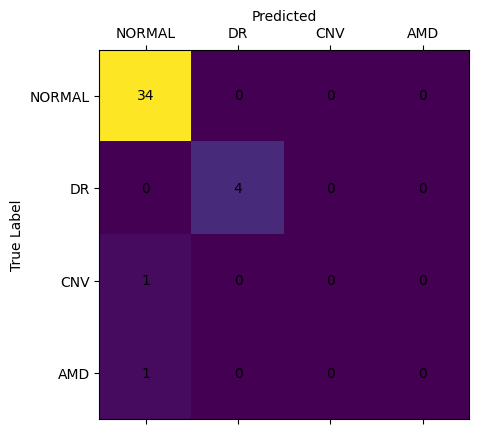

In [4]:
# selection of the features to use
num_features = train_list_bin[0].x.shape[1]
num_classes = 4
epochs = 100

# try different aggregation modes:
# other aggragtion schemas not supported for batches


# create the model
model = gnn_models.GCN_GC(in_channels= num_features, hidden_channels = 64, out_channels= num_classes, num_layers= 3, dropout = 0.2, aggregation_mode= global_mean_pool)

# create brach data loaders for training and test set
train_loader = DataLoader(train_list_bin, batch_size = 32, shuffle=True)
test_loader = DataLoader(test_list_bin, batch_size = 1, shuffle=False)

#train_loader = NeighborIterator(train_list_bin, neighborhood_size=50, start_node_fraction=0.01)
#test_loader = NeighborIterator(test_list_bin, neighborhood_size=50, start_node_fraction=0.01)

#train_loader = RectangularIterator(train_list_bin, selections_per_graph=10, rect_size=300)
#test_loader = RectangularIterator(test_list_bin, selections_per_graph=10, rect_size=300)

# weigthings for imbalanced classes 
train_labels = [lab["y"] for lab in train_list_bin]
weights = 1/np.unique(train_labels, return_counts= True)[1]
balanced_loss = torch.nn.CrossEntropyLoss(torch.tensor(weights).float())
unbalanced_loss = torch.nn.CrossEntropyLoss() # use when the training data is already balanced

# trainloader can be anything 
classifier = graph_classifier.graphClassifierClassic(model, train_loader, test_loader, balanced_loss)


for epoch in range(1, epochs+1):
    classifier.train()
    train_acc = classifier.test(train_loader)
    #test_acc = classifier.test(test_loader)
    outList, yList = classifier.predict(test_loader)
    y_p = np.array([item.argmax().detach().numpy() for sublist in outList for item in sublist])
    y_t = np.array([item.detach().numpy() for sublist in yList for item in sublist])
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {accuracy_score(y_t, y_p):.4f}, Test Bal Acc: {balanced_accuracy_score(y_t, y_p):.4f}')


fig, ax = plt.subplots()
evaluation.plot_confusion_matrix(y_t, y_p, ["NORMAL", "DR", "CNV", "AMD"], ax)
#evaluation.plot_confusion_matrix(y_t, y_p, ["NORMAL", "DR"], ax)

In [5]:
#test_loader_neighb = NeighborIterator(test_list_bin, neighborhood_size=50, start_node_fraction=0.01)
#train_loader_neighb = NeighborIterator(train_list_bin, neighborhood_size=50, start_node_fraction=0.01)
#
#train_loader_ = RectangularIterator(train_list_bin, selections_per_graph=10, rect_size=300)
#test_loader = RectangularIterator(test_list_bin, selections_per_graph=10, rect_size=300)

train_loader = DataLoader(train_list_bin, batch_size = 1, shuffle=True)
test_loader = DataLoader(test_list_bin, batch_size = 1, shuffle=False)

gen_epochs = 1

print("Acc is Bal. Acc (stratified)")
for epoch in range(1, gen_epochs+1):
    outList, yList = classifier.predict(test_loader)
    outList_train, yList_train = classifier.predict(train_loader)
    y_p = np.array([item.argmax().detach().numpy() for sublist in outList for item in sublist])
    y_t = np.array([item.detach().numpy() for sublist in yList for item in sublist])
    y_p_train = np.array([item.argmax().detach().numpy() for sublist in outList_train for item in sublist])
    y_t_train = np.array([item.detach().numpy() for sublist in yList_train for item in sublist])
    print(f'Generation Epoch: {epoch:03d}, Test Acc: {balanced_accuracy_score(y_t,y_p):.4f}, Train Acc: {balanced_accuracy_score(y_t_train, y_p_train):.4f}')


Acc is Bal. Acc (stratified)
Generation Epoch: 001, Test Acc: 0.5000, Train Acc: 0.3600


In [6]:
# show an example for the graph
#graph_2D.GraphPlotter2D(octa500_loader_2_cls.full_data[10301]).plot_graph_2D()

# show an example for the connected line graph
#graph_2D.GraphPlotter2D(octa500_loader_2_cls.line_data[10301], line_G = True).plot_graph_2D()

In [13]:
# evaluate on partitions:

#test_loader_regions = RectangularIterator(test_list_bin, selections_per_graph=100, rect_size=300, stratified= False, shuffle= False)
train_loader_regions = RectangularIterator(train_list_bin[:29], selections_per_graph=100, rect_size=300, stratified= False, shuffle= False)

loader_sel = train_loader_regions

outList, yList = classifier.predict(loader_sel)
last_id_list =loader_sel.last_id_list
last_region_list =loader_sel.last_region_list

In [14]:
def get_rel_regions_for_id(id, last_id_list, last_region_list, outList):
    idx = np.where(np.array(last_id_list) == id)
    outList_rel = np.array(outList)[idx] 
    return np.array(last_region_list)[idx], outList_rel


def append_region_val_to_dict(rel_regions,outlist_rel, pos_dict, val_dict):
    
    ct = 0
    for region in rel_regions:
        x_min = region[0]
        x_max = region[1]
        y_min = region[2]
        y_max = region[3]
        for node, pos in pos_dict.items():

            if x_min < pos[0] < x_max and y_min < pos[1] < y_max:
                val_dict[node].append(outlist_rel[ct][0,1]-outlist_rel[ct][0,0]) # if the difference is large, the model is confident

        ct +=1


def extract_mean_from_dict(node_dict_val):
    mean_vals = []
    for node, val in node_dict_val.items():
        if len(val) == 0:
            mean_vals.append(0)
        else:
            mean_vals.append(np.mean(val))

    mean_vals = np.array(mean_vals)
    mean_vals = mean_vals.reshape(-1,1)

    return mean_vals


def nodewise_mean_val(dataloader, node_id, id_list, region_list, pred_list):
    node_dict_pos = dict(zip(np.arange(0, dataloader.line_data[node_id].num_nodes), np.array(dataloader.line_data[node_id].edge_pos[:,:-1].detach().numpy())))
    node_dict_val = dict(zip(np.arange(0, dataloader.line_data[node_id].num_nodes), ([] for _ in np.arange(0, dataloader.line_data[node_id].num_nodes))))

    # extract all regions that were created for a graph
    rel_regions, rel_vals = get_rel_regions_for_id(node_id, id_list, region_list, pred_list)
    # extract the values for the regions and append to the fitting nodes
    append_region_val_to_dict(rel_regions,rel_vals, node_dict_pos, node_dict_val)

    # get the mean of the values for each node and append to the data object as a new feature
    mean_vals = extract_mean_from_dict(node_dict_val)

    return mean_vals

In [15]:
ids = [graph.graph_id for graph in train_list_bin]
labs = [int(graph.y[0]) for graph in train_list_bin]
np.where(np.array(labs) == 1)

(array([  3,   5,   9,  13,  15,  21,  28,  36,  39,  43,  53,  54,  64,
         66,  71,  92,  96, 106, 107, 110, 119, 123, 133, 142, 158]),)

In [18]:
np.array(outList[:2000])

array([[[ 1.8145609 , -1.9497359 ,  0.2626205 ,  0.15612124]],

       [[ 1.4813113 , -1.5832728 ,  0.21463619,  0.18572639]],

       [[ 2.2051995 , -2.3371775 ,  0.31599015,  0.14964226]],

       ...,

       [[ 1.8858442 , -2.0032656 ,  0.27067035,  0.16676481]],

       [[ 1.5911214 , -1.7173101 ,  0.23957504,  0.17611018]],

       [[ 1.5897434 , -1.681011  ,  0.22232601,  0.17746305]]],
      dtype=float32)

1
10302


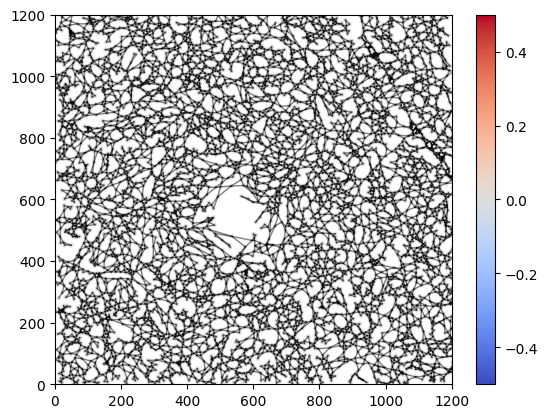

3
10304


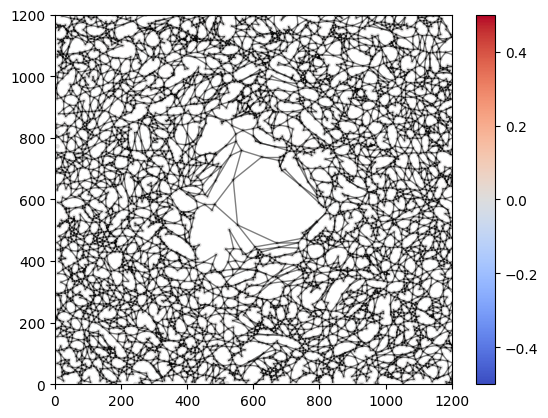

5
10306


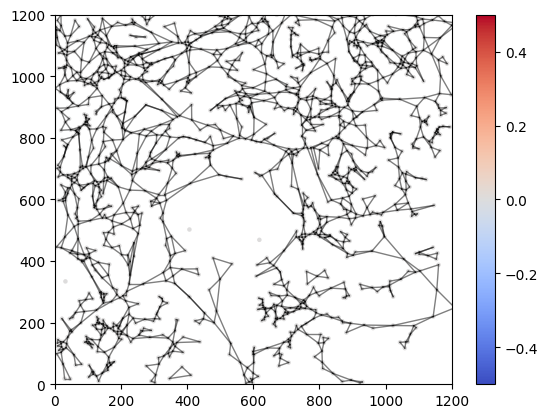

7
10308


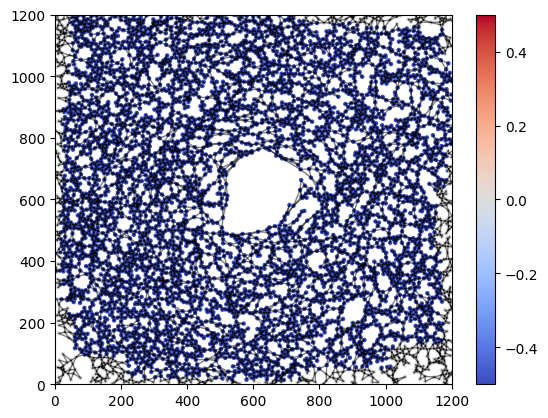

9
10311


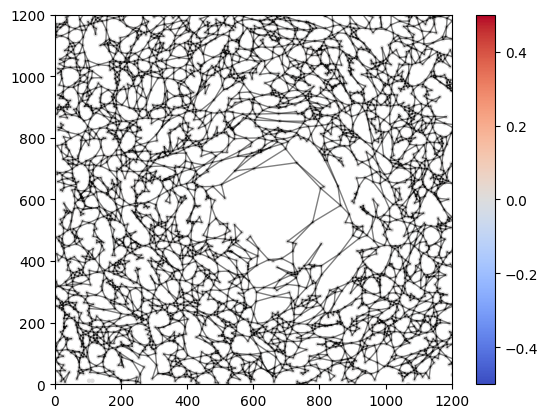

11
10313


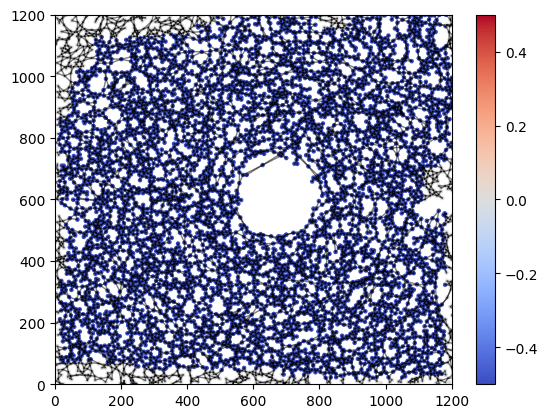

13
10315


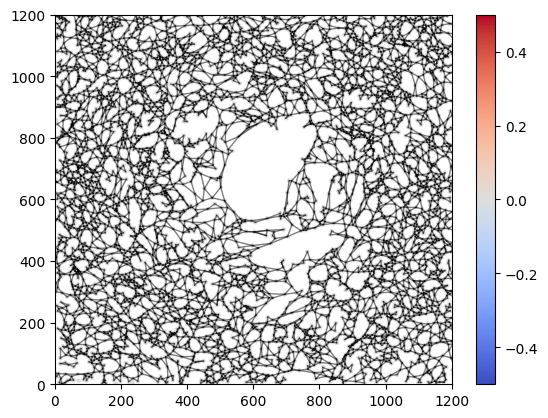

15
10317


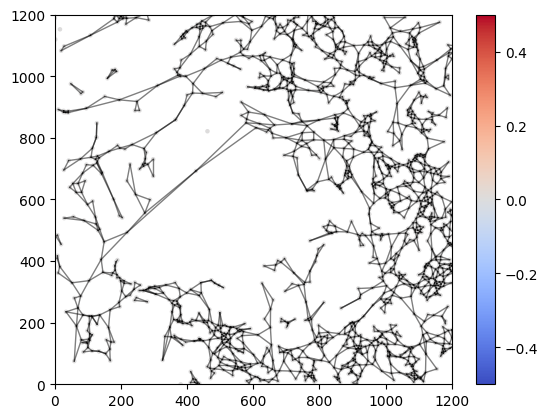

17
10319


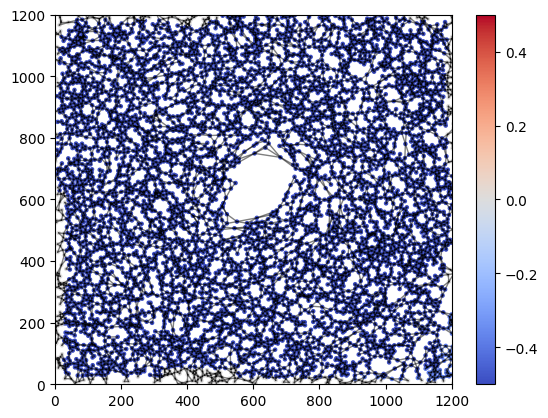

19
10321


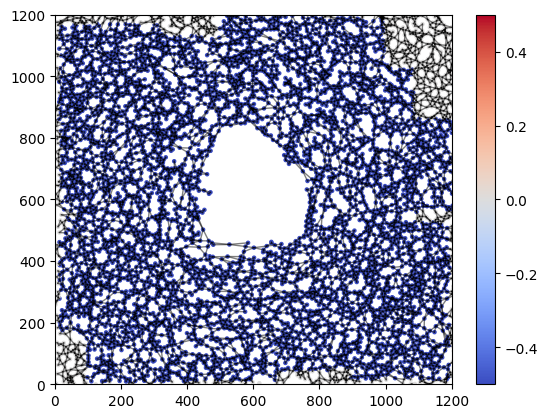

21
10324


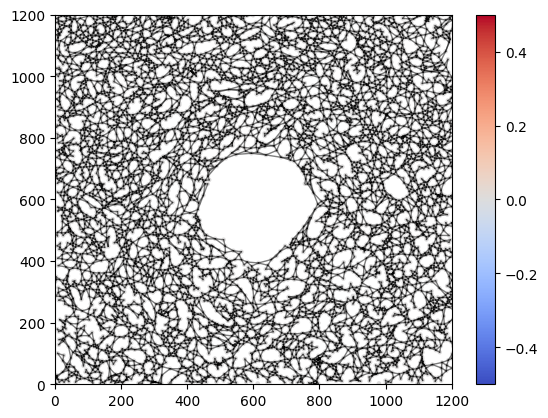

23
10327


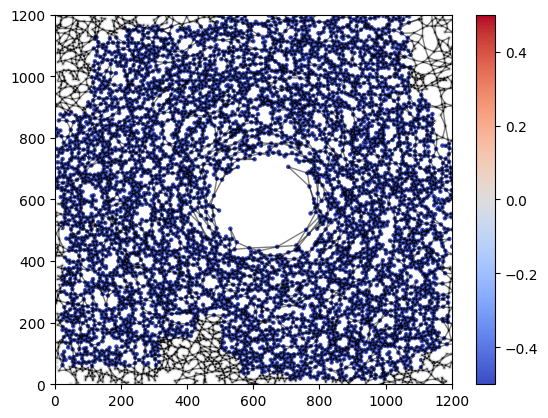

25
10329


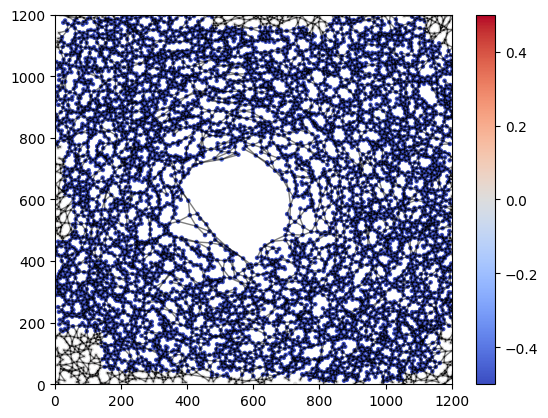

27
10334


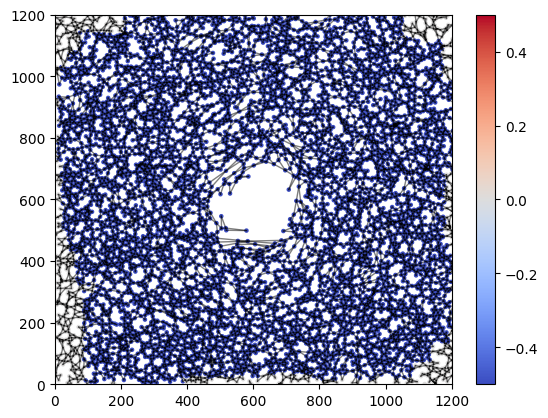

29
10336


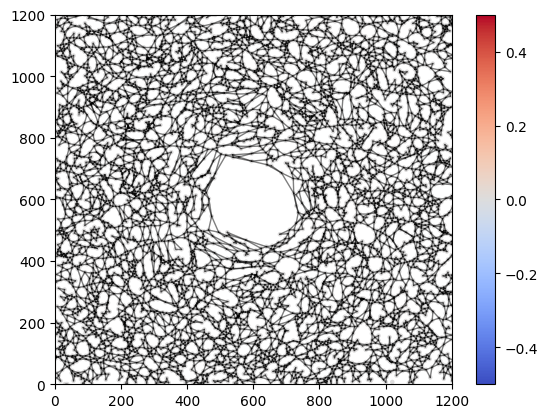

In [19]:

for n_id_idx in np.arange(1,31,2):
    n_id = ids[n_id_idx]
    print(n_id_idx)
    print(n_id)
    mean_vals = nodewise_mean_val(octa500_loader_4_cls, n_id, last_id_list[:2000], last_region_list[:2000], outList[:2000])
    graph_2D.GraphPlotter2D(octa500_loader_4_cls.line_data[n_id], line_G = True, pred_vals=mean_vals).plot_graph_2D()

In [12]:
train_loader_regions = RectangularIterator(train_list_bin[21:23], selections_per_graph=100, rect_size=300, stratified= True, shuffle= True)


for region_graph in train_loader_regions:
    graph_2D.GraphPlotter2D(region_graph, line_G = True).plot_graph_2D()
    print(region_graph.region)
    break
    